In [1]:
import sys
from astropy.io import fits
import requests as r
!pip install tqdm
%matplotlib inline
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!mkdir -p /project/lofarsw/Data/Dynspec
DYNSPEC_OUT = "/project/lofarsw/Data/Dynspec"
def extract_fits(files):
  result, *_ = filter(lambda x: x.endswith('.fits'), files)
  return result

query = "https://spaceweather.astron.nl/api2/solar_bf_compressing/tasks/?filter={%22date%22:{%22$gt%22:%222022-05-01%22}}"
dates_url = {}
additional_data = {}


def key(res):
  return '_'.join([res['obsID'], res['date'], res['time']])

while True:
  result = r.get(query).json()
  next_result = result['next']

  dates_url.update({key(res): extract_fits(res['additional_files_url']) for res in result['results']})
  
  additional_data.update({key(res): {'time_range': res['time_range'], 'freq_range': res['freq_range']} for res in result['results']})
  query = next_result
  if not result['results']:
    break



In [3]:
dates, urls = list(zip(*dates_url.items()))


In [4]:
from tqdm import tqdm

def sigmoid(x, s, c):
  return 1 / (1 + np.exp(-(x-c)/s))

from tensorflow.image import resize
def download_and_normalize(url):
  imdata = fits.open(url)[0].data
  
  imdata = imdata #/ np.nanmax(imdata)
  normalization = np.mean(
            np.sort(imdata, 0)[
            int(imdata.shape[0] * 0.1):int(imdata.shape[0] * 0.3), :], 0)
  
  normalized = imdata/normalization
  vmin, vmax = np.percentile(normalized, (20, 80))
  #vmax = np.nanmedian(normalized) 
  center = np.mean([vmax, vmin])
  scale = vmax-vmin
  normalized = sigmoid(normalized, scale, center)
  
  normalized = normalized.reshape([*normalized.shape, 1] )
  normalized = resize(normalized, (500, 800)).numpy()
  return normalized[:, :, 0]



2023-04-05 21:53:04.966258: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 21:53:06.093396: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


https://spaceweather.astron.nl/SolarKSP/data/atdb_process/solar_bf_compressing/4141/884132/dynamic_spectra/LOFAR_20230317_131500_LBA_OUTER_S0.fits


2023-04-05 21:53:19.213555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 21:53:21.724618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 21:53:21.725312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 21:53:21.734851: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, r

(500, 800)

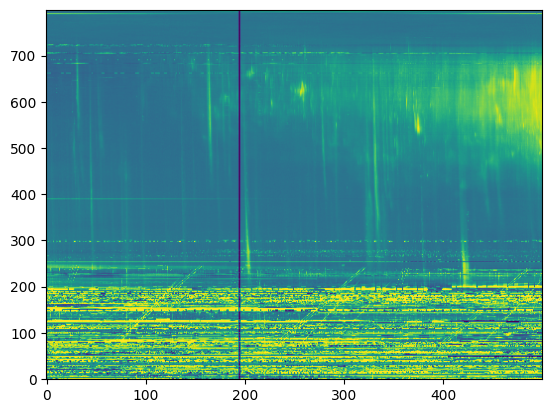

In [5]:
#test_url = urls[30]
test_url = 'https://spaceweather.astron.nl/SolarKSP/data/atdb_process/solar_bf_compressing/4141/884132/dynamic_spectra/LOFAR_20230317_131500_LBA_OUTER_S0.fits'
#test_url = 'https://spaceweather.astron.nl/SolarKSP/data/atdb_process/solar_bf_compressing/4141/884132/dynamic_spectra/LOFAR_20230317_130000_LBA_OUTER_S0.fits'

print(test_url)
image = download_and_normalize(test_url)

plt.imshow(image[:, :].T, origin='lower', aspect='auto')
image.shape

In [6]:
# DOWNLOAD AND NORMALIZE THEM ALL
dims = download_and_normalize(urls[0]).shape
print('Dims are', dims)
finalshape = tuple(map(int, [len(urls), *dims]))
path = DYNSPEC_OUT + '/dset.mmap'
print(finalshape, path)
resultant = np.memmap(path, dtype='float32', mode='w+', shape=finalshape)
skipped = []
for i, url in tqdm(enumerate(urls), total=len(urls)):
  image = download_and_normalize(url)
  if np.sum(image.shape) == np.sum(dims):
    resultant[i, :, :] = download_and_normalize(url)
  else:
    skipped.append(i)
    print('Skipped', i)

Dims are (500, 800)
(8147, 500, 800) /project/lofarsw/Data/Dynspec/dset.mmap


  1%|          | 48/8147 [00:27<52:36,  2.57it/s]  /tmp/ipykernel_1152131/1805804429.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(x-c)/s))
  5%|▍         | 399/8147 [04:00<1:22:27,  1.57it/s]/tmp/ipykernel_1152131/1805804429.py:15: RuntimeWarning: invalid value encountered in true_divide
  normalized = imdata/normalization
  5%|▌         | 425/8147 [04:12<1:08:38,  1.88it/s]/tmp/ipykernel_1152131/1805804429.py:15: RuntimeWarning: divide by zero encountered in true_divide
  normalized = imdata/normalization
 67%|██████▋   | 5499/8147 [55:53<24:20,  1.81it/s]  /usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 8147/8147 [1:22:24<00:00,  1.71it/s]


In [7]:
mean_total = np.nanmean(resultant, axis=0)[:, :].T
sum_total = np.nansum(resultant, axis=0)[:, :].T
std_total = np.nanstd(resultant, axis=0)[:, :].T

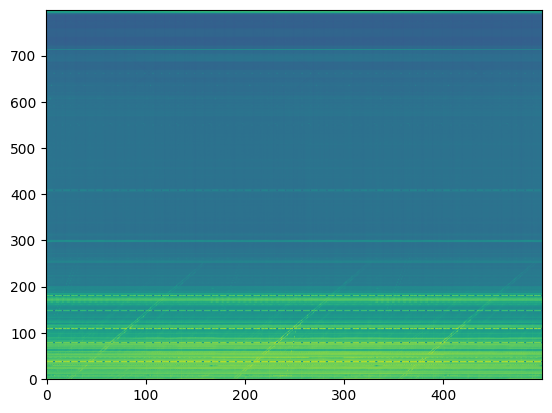

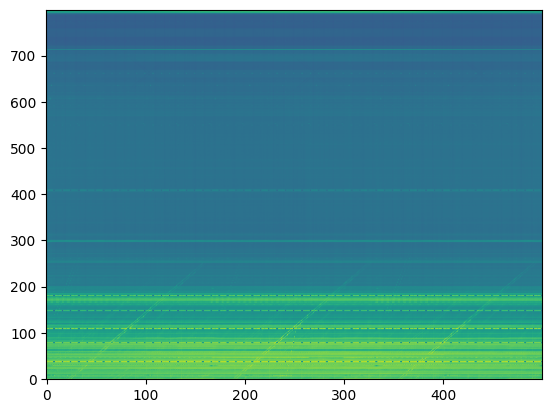

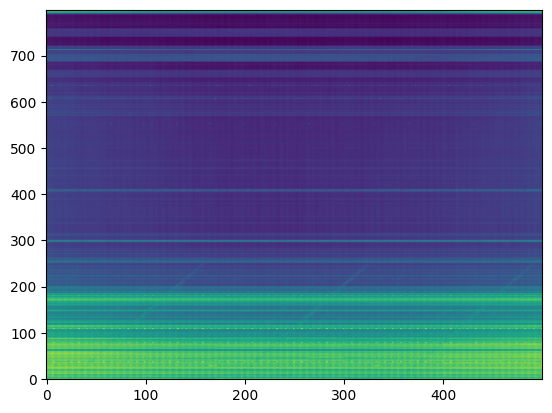

In [8]:
plt.figure()
plt.imshow(mean_total, aspect='auto', origin='lower')
plt.figure()
plt.imshow(sum_total, aspect='auto', origin='lower')
plt.figure()
plt.imshow(std_total, aspect='auto', origin='lower')

'860282_2022-05-16_16:00:00.000000'

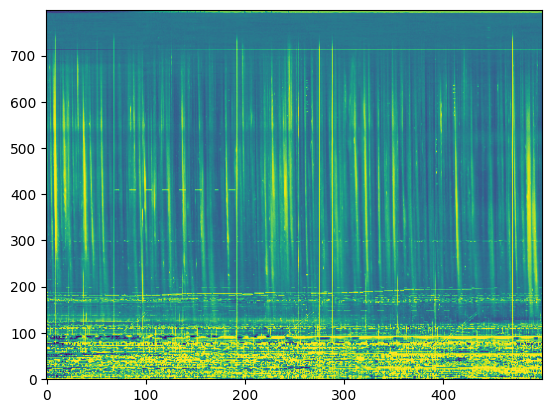

In [12]:
plt.figure()
plt.imshow(resultant[563, :, :].T, aspect='auto', origin='lower')
dates[563]


In [14]:
from datetime import datetime

def sec_to_timestamp(sec):
  return [datetime.fromisoformat(s).timestamp() for s in sec]

freq_range = [list(map(float,additional_data[date]['freq_range'])) for date in dates]
time_range = [sec_to_timestamp(additional_data[date]['time_range']) for date in dates]
import h5py
path = DYNSPEC_OUT + '/dset.mmap'
path_h5 = path.replace('.mmap', '.h5')
with h5py.File(path_h5, 'w') as dspec_set:

  dspec_set['/data'] = resultant
  dspec_set['/timestamps'] = dates
  dspec_set['/freq_range'] = np.array(freq_range)
  dspec_set['/time_range'] = np.array(time_range)


In [15]:
import h5py
import os.path as path
from tqdm import tqdm, tqdm_notebook
import os
path_h5 = "/project/lofarsw/Data/Dynspec/dset.h5"
base_path = 'galaxyzoo/output'
!rm -rf galaxyzoo/output
os.makedirs(base_path, exist_ok=True)
from datetime import datetime
def save_one(base_path, timestamp, data,freq, time, dpi=100, pixels=500):
  filename = timestamp.decode() + '.png'
  output_path = path.join(base_path, filename)
  fig = plt.figure(figsize=(pixels/dpi, pixels/dpi), dpi=dpi)
  fig.set_layout_engine('constrained')
  ax = fig.add_subplot(111)
  ax.set_position([.12, .11, .85, .85])
  
  ax.imshow(data.T, origin='lower', aspect='auto', extent=[0, 15, freq[0], freq[1]])
  ax.set_ylabel('Frequency [MHz]')
  ax.set_xlabel('Time [min]')
  fig.savefig(output_path, dpi=dpi)
  plt.close(fig)
  return filename

    
with h5py.File(path_h5, 'r') as dspec_set:
  data = dspec_set['/data']
  timestamps = dspec_set['timestamps']
  time_range = dspec_set['time_range']
  freq_range = dspec_set['freq_range']
  
  with open(path.join(base_path, 'offset.csv'), 'w') as f_out:
    f_out.write('100 950 950 50')
  with open(path.join(base_path, 'summary.csv'), 'w') as f_out:
    f_out.write('ID;IMAGE;#KEY;FREQ_START;FREQ_END;#T_START;#T_END;MIN_V;MAX_V\n')
    for k in tqdm(range(len(timestamps))):
      if (np.isnan(data[k].sum())):
        continue
      f_name = save_one(base_path, timestamps[k], data[k], freq_range[k], time_range[k])
      f_out.write('{};{};{};{};{};{};{};{};{}\n'.format(k, f_name,timestamps[k].decode(), freq_range[k][0], freq_range[k][1], time_range[k][0], time_range[k][1], np.min(data[k]), data[k].max()))
  
  


100%|██████████| 8147/8147 [26:17<00:00,  5.29it/s]

In [ ]:
path_h5
